# Moonshot Model: Rate of Change

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import warnings
import datetime
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver

#### Uncomment and Run below only to pull entire history

### Load data and clean

In [3]:
dt_meta = pd.read_csv('MarketCapTable.csv')

def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)
dt_meta['Price'] = dt_meta['Price'].apply(clean_currency).astype('float')
dt_meta['Date'] = pd.to_datetime(dt_meta['Date'])
dt_meta.sort_values(by = "Date", ascending = True, inplace = True)


dtraw = dt_meta.loc[:,["Date", "Symbol", "Rank"]]
#Remove stablecoins
remove = ['USDT', 'BUSD', 'UST', 'USDC']
for stk in remove:
    dtraw.drop(dtraw[dtraw["Symbol"]==stk].index, inplace = True)
dtraw.reset_index(drop = True, inplace = True)
dtraw

,Date,Symbol,Rank
0,2013-04-28,NVC,7
1,2013-04-28,BTC,1
2,2013-04-28,LTC,2
3,2013-04-28,DVC,6
4,2013-04-28,NMC,4
...,...,...,...
82173,2021-11-28,BAT,67
82174,2021-11-28,QNT,68
82175,2021-11-28,STX,69
82176,2021-11-28,ONE,59


### Calculate Rank Score from Bollinger Band Transformation Signal

In [4]:
def roc(df, n):
    return (df.diff(n - 1) / df.shift(n - 1)) * 100

In [5]:
dt_check = dtraw.loc[:,["Date", "Symbol", "Rank"]]
coins = list(dt_check["Symbol"].unique())
for coin in coins:
    dt_temp = dt_check[dt_check["Symbol"]==coin]
    dt_temp["Score"] = roc(dt_temp["Rank"], 52)
    dt_temp.dropna(inplace = True)
    if coins.index(coin) == 0:
        dt = dt_temp
    else:
        dt = pd.concat([dt, dt_temp], axis = 0, ignore_index=True)
dt

,Date,Symbol,Rank,Score
0,2014-04-20,NVC,19,171.428571
1,2014-04-27,NVC,19,111.111111
2,2014-05-04,NVC,20,300.000000
3,2014-05-11,NVC,20,300.000000
4,2014-05-18,NVC,21,320.000000
...,...,...,...,...
39301,2021-11-07,NEAR,39,-31.578947
39302,2021-11-14,NEAR,36,-46.268657
39303,2021-11-21,NEAR,39,-44.285714
39304,2021-11-28,NEAR,42,-41.666667


### Create matrix of top 10 coins by date from Score Calculated above

In [6]:
table = pd.pivot_table(dt,index=['Symbol'], columns = 'Date', values = "Score")
topcoins = table.copy()

for i in range(0,len(topcoins.columns)):
    topcoins.iloc[:,i] = topcoins.iloc[:,i].sort_values(ascending = False).index
topcoins = topcoins[0:30]
topcoins.index = range(len(topcoins))
topcoins_raw = topcoins.copy()
topcoins = topcoins[0:10].transpose()
topcoins.tail(10)

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2021-09-26,BSV,CRO,HT,XEM,BCH,EOS,UMA,ONT,ANT,REP
2021-10-03,BSV,BCH,HT,CRO,XEM,UMA,EOS,ANT,ONT,ZEC
2021-10-10,BSV,BCH,HT,UMA,XEM,CRO,EOS,ONT,EWT,LEO
2021-10-17,BSV,BCH,HT,EOS,UMA,XEM,LINK,ONT,XMR,LEO
2021-10-24,BSV,BCH,HUSD,EOS,XEM,UMA,ONT,HT,XMR,REP
2021-10-31,BSV,BCH,HUSD,AMPL,XEM,EOS,EWT,XMR,UMA,HT
2021-11-07,AMPL,BSV,XEM,BCH,EOS,EWT,XMR,LINK,HT,LEO
2021-11-14,BSV,EOS,XEM,LEO,LINK,HT,XMR,YFI,EWT,CEL
2021-11-21,BSV,XEM,BCH,HUSD,LINK,REV,EOS,CEL,ONT,DASH


### Create rolling portfolio of top 10 equally weighted coins

In [7]:
weightdf = pd.DataFrame(index = topcoins.index, columns = coins)

for row in weightdf.index:
    for col in weightdf.columns:
        if col in topcoins.loc[row].values:
            weightdf.loc[row,col]=0.1
weightdf.fillna(0, inplace = True)

dfret = pd.pivot_table(dt_meta,index=['Date'], columns = 'Symbol', values = "Price")
dfret = dfret.pct_change().apply(lambda x: np.log(1+x))
dfret = dfret.loc[weightdf.index,weightdf.columns]
dfret.fillna(0, inplace = True)

weight_port = weightdf.copy()
dfret["Port_Ret"] = np.nan
for row in weight_port.index:
    dfret.loc[row,"Port_Ret"] = sum(weight_port.loc[row,:] * dfret.shift(-1).loc[row,][:-1])

### Backtest rolling portfolio

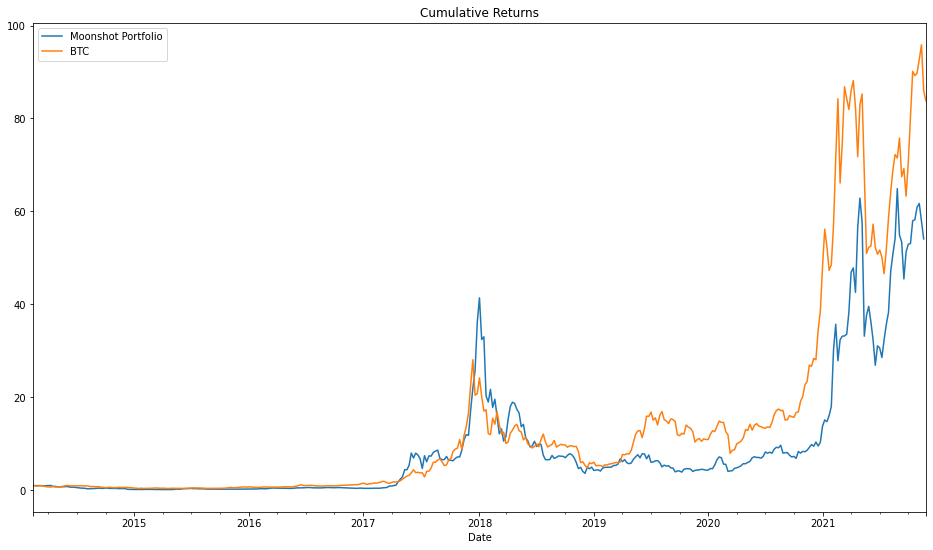

In [8]:
dfret[["Port_Ret", "BTC"]].cumsum().apply(np.exp).plot(figsize = (16,9))
plt.title("Cumulative Returns")
plt.legend(["Moonshot Portfolio", "BTC"])
plt.show()

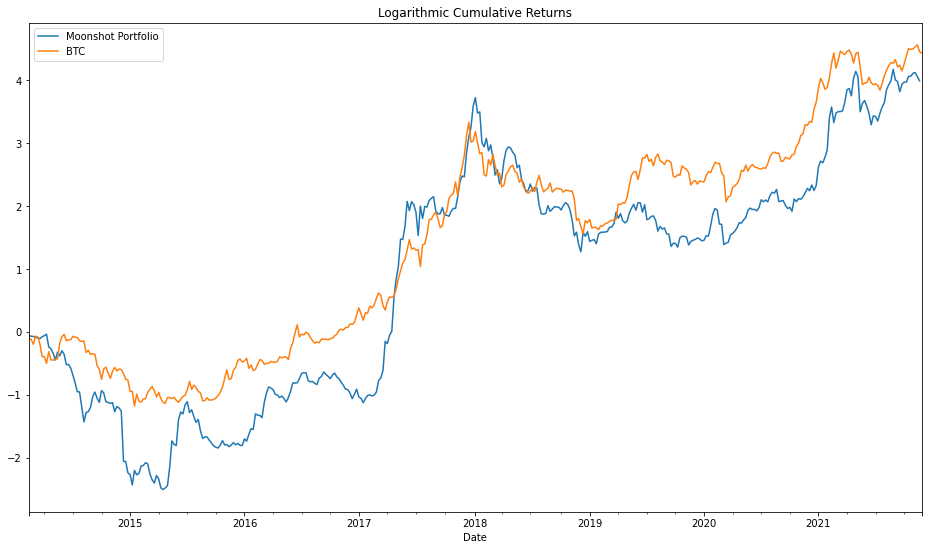

In [9]:
dfret[["Port_Ret", "BTC"]].cumsum().plot(figsize = (16,9))
plt.legend(["Moonshot Portfolio", "BTC"])
plt.title("Logarithmic Cumulative Returns")
plt.show()

### Portfolio Performance Stats

In [10]:
sharpe = dfret["Port_Ret"].mean()/dfret["Port_Ret"].std()*np.sqrt(253)
print("Shape Ratio of the Moonshot Portfolio is " + str(round(sharpe,2)))

Shape Ratio of the Moonshot Portfolio is 1.14


In [11]:
D = (dfret.index[-1] - dfret.index[0]).days
cagr = ((((dfret["Port_Ret"].cumsum().apply(np.exp)[-2]) ** (365.0/D)) - 1)*100)
print("CAGR of the Moonshot Portfolio is " + str(round(cagr,2)) + "%")

CAGR of the Moonshot Portfolio is 66.94%
